# DIP Training for Denoising

testing the first python implementations

In [1]:
!nvidia-smi

Sat May  1 07:42:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    25W /  N/A |    403MiB /  7982MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import copy
%config Completer.use_jedi = False

In [3]:
from skimage.metrics import peak_signal_noise_ratio #import compare_psnr

In [4]:
import sys
sys.path.append("../src")
sys.path.append("../src/model")
sys.path.append("../src/utils")
sys.path.append("../src/training_pipeline")
sys.path.append("../")

In [5]:
from model.skip_net import *
from utils.data_processing import *
from utils.data_plotting import *
from training_pipeline.dip import *

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        #tf.config.experimental.set_virtual_device_configuration(
        #gpus[0],
        #[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2024)])
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Processing

## Input image and noisy image

In [7]:
sigma = 25
sigma_ = sigma/255.
img = load_image("../data/original/F16_GT.png")
img_noise = get_noise_image(img, sigma_)

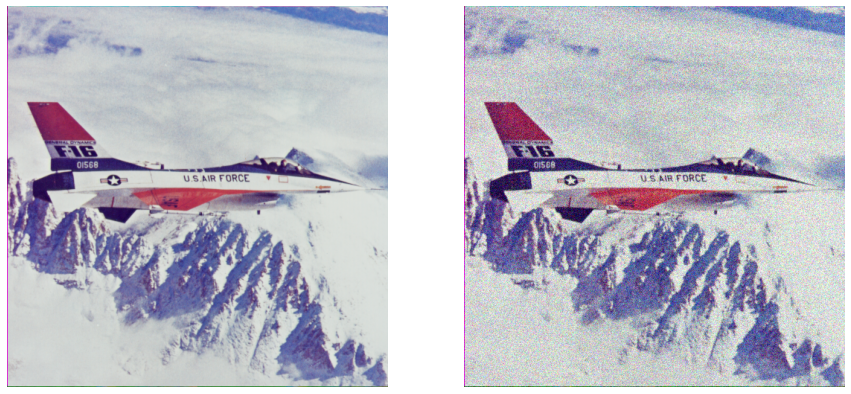

In [8]:
plot_images([img, img_noise])

In [9]:
image_information(img)
image_information(img_noise)

dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (512, 512, 3) , range: 0.0 - 0.9176470637321472
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (512, 512, 3) , range: 0.0 - 1.0


In [10]:
print("PSNR = ", peak_signal_noise_ratio(img_noise, img))

PSNR =  20.358910041070878


## Network input

In [11]:
net_input = get_network_input((1,512,512,32))
image_information(net_input)

dtype:  <dtype: 'float32'> , type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
size:  (1, 512, 512, 32) , range: 0.0 - 0.09999998658895493


# Model

In [12]:
model = skip_net(nb_filters_down=[128,128,128,128, 128])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 32)]  0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (1, 514, 514, 32)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 256, 256, 128)   36992       reflection_padding2d[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 256, 256, 128)   512         conv2d[0][0]                     
______________________________________________________________________________________________

# Training

In [13]:
learning_rate = 0.01
num_iter = 3000
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-08, amsgrad=False,name='Adam')
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)

In [14]:
training = DIPTraining(model, mse, adam)

In [15]:
training.set_callbacks(checkpoint='train_run/denoising/dn.ckpt')

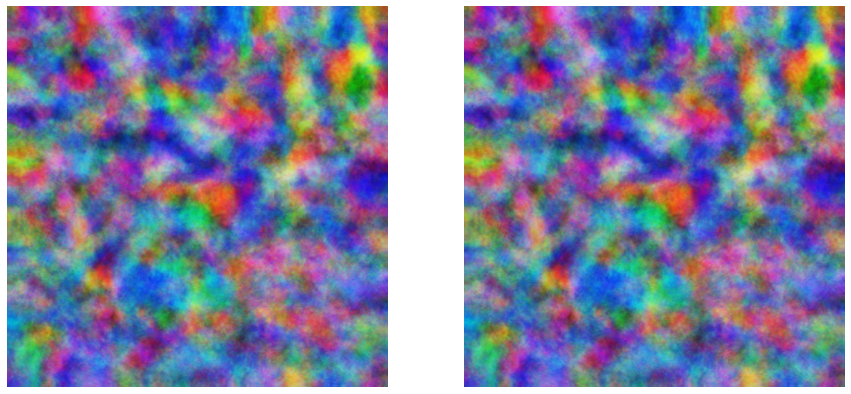

Iteration 00001    Loss 0.089361   PSNR_corrupted: 10.488543   PSRN_gt: 10.955830 PSNR_gt_sm: 9.391276 
Iteration 00001    PSNR_GT improved from 10.955830 to 9.291562. Save model to train_run/denoising/dn.ckpt
Iteration 00003    Loss 0.095669   PSNR_corrupted: 10.192309   PSRN_gt: 10.629054 PSNR_gt_sm: 9.591959 
Iteration 00003    PSNR_GT improved from 10.629054 to 10.426062. Save model to train_run/denoising/dn.ckpt
Iteration 00004    Loss 0.076681   PSNR_corrupted: 11.153115   PSRN_gt: 11.695928 PSNR_gt_sm: 9.660718 
Iteration 00004    PSNR_GT improved from 11.695928 to 10.629054. Save model to train_run/denoising/dn.ckpt
Iteration 00005    Loss 0.068521   PSNR_corrupted: 11.641751   PSRN_gt: 12.260043 PSNR_gt_sm: 9.747068 
Iteration 00005    PSNR_GT improved from 12.260043 to 11.695928. Save model to train_run/denoising/dn.ckpt
Iteration 00006    Loss 0.053379   PSNR_corrupted: 12.726323   PSRN_gt: 13.533955 PSNR_gt_sm: 9.832800 
Iteration 00006    PSNR_GT improved from 13.533955 to

Iteration 00060    Loss 0.024388   PSNR_corrupted: 16.128293   PSRN_gt: 18.134250 PSNR_gt_sm: 13.458675 
Iteration 00060    PSNR_GT improved from 18.134250 to 18.127113. Save model to train_run/denoising/dn.ckpt
Iteration 00061    Loss 0.023696   PSNR_corrupted: 16.253326   PSRN_gt: 18.335794 PSNR_gt_sm: 13.518562 
Iteration 00061    PSNR_GT improved from 18.335794 to 18.134250. Save model to train_run/denoising/dn.ckpt
Iteration 00063    Loss 0.023660   PSNR_corrupted: 16.259889   PSRN_gt: 18.357504 PSNR_gt_sm: 13.642554 
Iteration 00063    PSNR_GT improved from 18.357504 to 18.247521. Save model to train_run/denoising/dn.ckpt
Iteration 00064    Loss 0.023399   PSNR_corrupted: 16.308099   PSRN_gt: 18.421806 PSNR_gt_sm: 13.702873 
Iteration 00064    PSNR_GT improved from 18.421806 to 18.357504. Save model to train_run/denoising/dn.ckpt
Iteration 00065    Loss 0.022828   PSNR_corrupted: 16.415284   PSRN_gt: 18.602120 PSNR_gt_sm: 13.763139 
Iteration 00065    PSNR_GT improved from 18.602

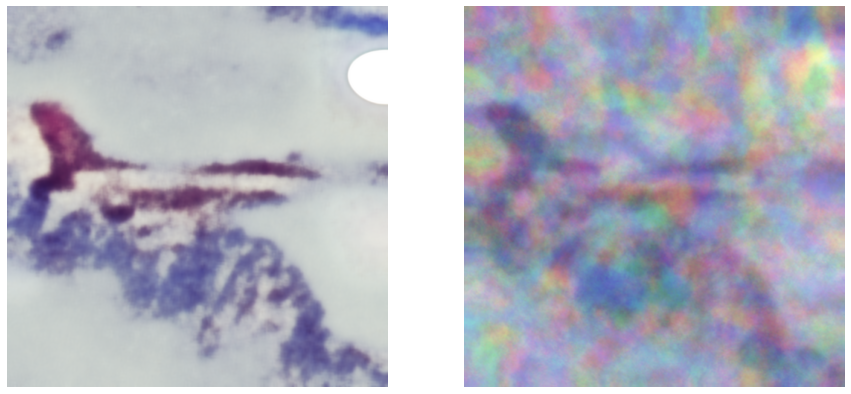

Iteration 00101    Loss 0.018633   PSNR_corrupted: 17.297239   PSRN_gt: 20.200410 PSNR_gt_sm: 15.903934 
Iteration 00101    PSNR_GT improved from 20.200410 to 20.158603. Save model to train_run/denoising/dn.ckpt
Iteration 00103    Loss 0.018490   PSNR_corrupted: 17.330536   PSRN_gt: 20.261002 PSNR_gt_sm: 16.022154 
Iteration 00103    PSNR_GT improved from 20.261002 to 20.158961. Save model to train_run/denoising/dn.ckpt
Iteration 00104    Loss 0.018278   PSNR_corrupted: 17.380788   PSRN_gt: 20.358395 PSNR_gt_sm: 16.078029 
Iteration 00104    PSNR_GT improved from 20.358395 to 20.261002. Save model to train_run/denoising/dn.ckpt
Iteration 00105    Loss 0.018232   PSNR_corrupted: 17.391631   PSRN_gt: 20.380334 PSNR_gt_sm: 16.133332 
Iteration 00105    PSNR_GT improved from 20.380334 to 20.358395. Save model to train_run/denoising/dn.ckpt
Iteration 00107    Loss 0.018208   PSNR_corrupted: 17.397467   PSRN_gt: 20.393967 PSNR_gt_sm: 16.242902 
Iteration 00107    PSNR_GT improved from 20.393

Iteration 00173    Loss 0.015881   PSNR_corrupted: 17.991162   PSRN_gt: 21.672901 PSNR_gt_sm: 19.442447 
Iteration 00173    PSNR_GT improved from 21.672901 to 21.655017. Save model to train_run/denoising/dn.ckpt
Iteration 00174    Loss 0.015668   PSNR_corrupted: 18.049794   PSRN_gt: 21.818739 PSNR_gt_sm: 19.481779 
Iteration 00174    PSNR_GT improved from 21.818739 to 21.672901. Save model to train_run/denoising/dn.ckpt
Iteration 00176    Loss 0.015410   PSNR_corrupted: 18.121917   PSRN_gt: 21.995445 PSNR_gt_sm: 19.562768 
Iteration 00176    PSNR_GT improved from 21.995445 to 21.701262. Save model to train_run/denoising/dn.ckpt
Iteration 00180    Loss 0.015590   PSNR_corrupted: 18.071424   PSRN_gt: 21.870571 PSNR_gt_sm: 19.721601 
Iteration 00180    PSNR_GT improved from 21.870571 to 21.748863. Save model to train_run/denoising/dn.ckpt
Iteration 00181    Loss 0.015426   PSNR_corrupted: 18.117560   PSRN_gt: 21.975215 PSNR_gt_sm: 19.761313 
Iteration 00181    PSNR_GT improved from 21.975

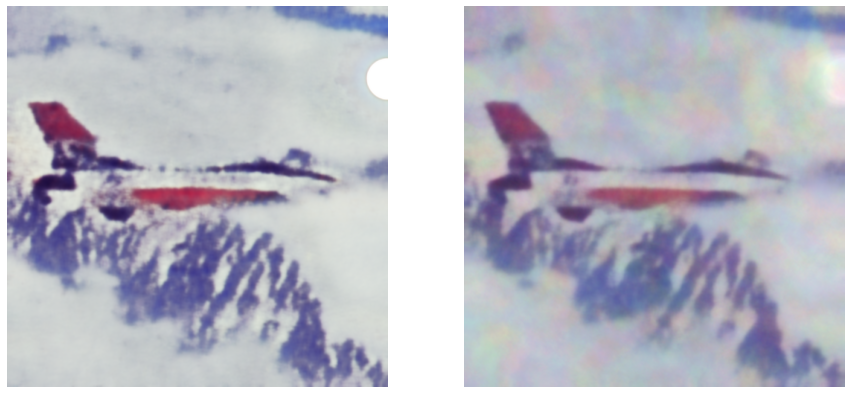

Iteration 00201    Loss 0.015001   PSNR_corrupted: 18.238935   PSRN_gt: 22.287803 PSNR_gt_sm: 20.501395 
Iteration 00201    PSNR_GT improved from 22.287803 to 22.183869. Save model to train_run/denoising/dn.ckpt
Iteration 00203    Loss 0.014855   PSNR_corrupted: 18.281407   PSRN_gt: 22.386657 PSNR_gt_sm: 20.567156 
Iteration 00203    PSNR_GT improved from 22.386657 to 22.259957. Save model to train_run/denoising/dn.ckpt
Iteration 00205    Loss 0.014828   PSNR_corrupted: 18.289133   PSRN_gt: 22.411733 PSNR_gt_sm: 20.640049 
Iteration 00205    PSNR_GT improved from 22.411733 to 22.294288. Save model to train_run/denoising/dn.ckpt
Iteration 00209    Loss 0.014867   PSNR_corrupted: 18.277791   PSRN_gt: 22.360492 PSNR_gt_sm: 20.770618 
Iteration 00209    PSNR_GT improved from 22.360492 to 22.339937. Save model to train_run/denoising/dn.ckpt
Iteration 00210    Loss 0.014878   PSNR_corrupted: 18.274602   PSRN_gt: 22.375417 PSNR_gt_sm: 20.805928 
Iteration 00210    PSNR_GT improved from 22.375

Iteration 00272    Loss 0.013847   PSNR_corrupted: 18.586464   PSRN_gt: 23.223286 PSNR_gt_sm: 22.485793 
Iteration 00272    PSNR_GT improved from 23.223286 to 23.052395. Save model to train_run/denoising/dn.ckpt
Iteration 00274    Loss 0.013846   PSNR_corrupted: 18.586766   PSRN_gt: 23.221902 PSNR_gt_sm: 22.529165 
Iteration 00274    PSNR_GT improved from 23.221902 to 23.206301. Save model to train_run/denoising/dn.ckpt
Iteration 00275    Loss 0.013852   PSNR_corrupted: 18.584891   PSRN_gt: 23.223454 PSNR_gt_sm: 22.550435 
Iteration 00275    PSNR_GT improved from 23.223454 to 23.221902. Save model to train_run/denoising/dn.ckpt
Iteration 00276    Loss 0.013833   PSNR_corrupted: 18.590891   PSRN_gt: 23.239138 PSNR_gt_sm: 22.572256 
Iteration 00276    PSNR_GT improved from 23.239138 to 23.223454. Save model to train_run/denoising/dn.ckpt
Iteration 00281    Loss 0.013781   PSNR_corrupted: 18.607216   PSRN_gt: 23.291386 PSNR_gt_sm: 22.678177 
Iteration 00281    PSNR_GT improved from 23.291

In [16]:
training.train_denoising(net_input, img_noise, img, num_iter=300)

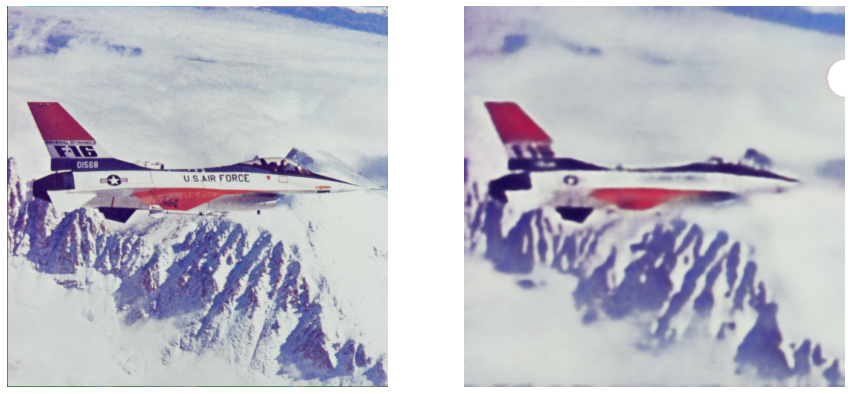

PSNR:  24.104692732753144


In [17]:
out_np = training._model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

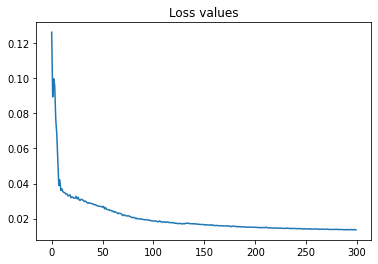

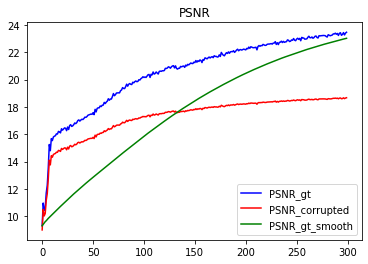

In [18]:
training.plot_history()

# Reinit model and load weights

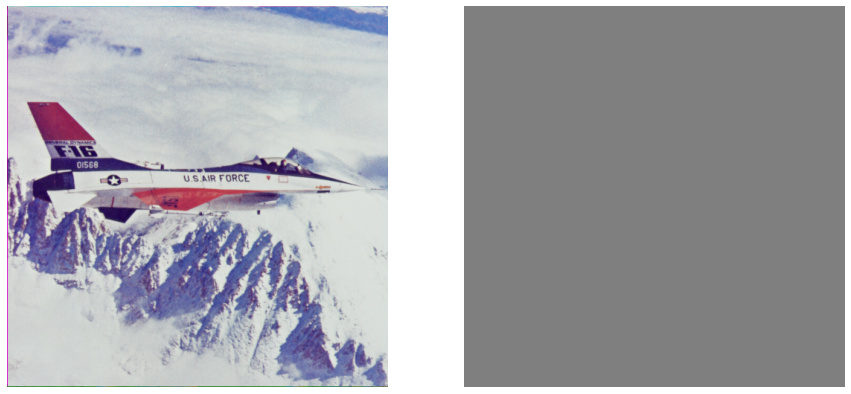

PSNR:  11.240042056875897


In [19]:
# reinit model
model = skip_net(nb_filters_down=[128,128,128,128, 128])
out_np = model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

In [20]:
# load weights
model.load_weights('train_run/denoising/dn.ckpt')

# Results

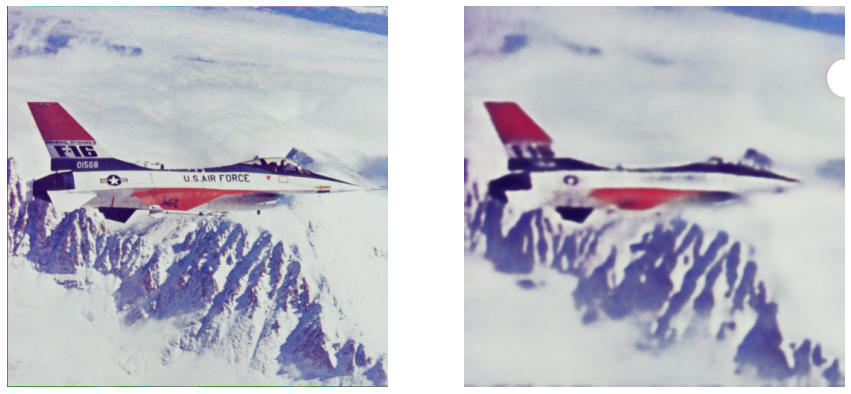

PSNR:  24.184808203530586


In [21]:
# inference of model
out_np = model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

Images


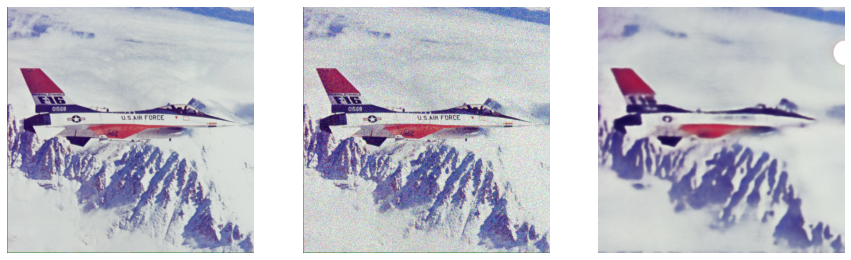

Images with cut outs


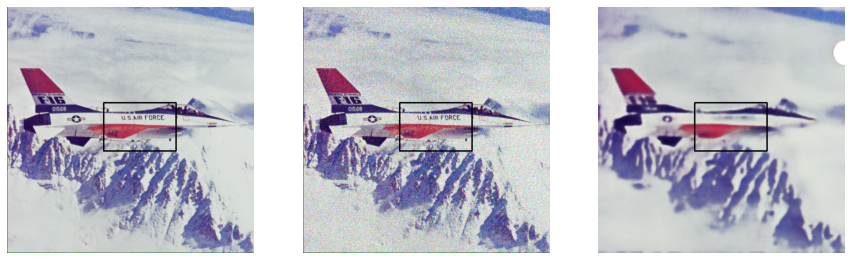

Cut outs


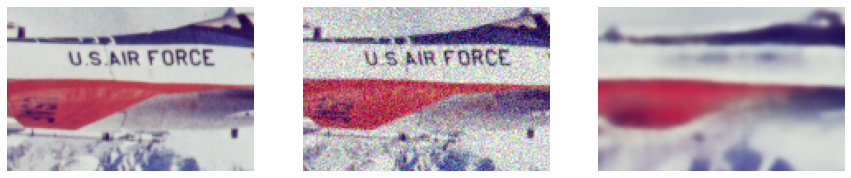

In [22]:
plot_cut_outs([img, img_noise, out_np], [200,200, 350,300])